In [1]:
from torch import nn, cuda, device, FloatTensor, as_tensor, int64, optim, argmax, no_grad
from torch.cuda import is_available
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import csv
import torch
import seaborn as sns
import matplotlib.pyplot as plt


# Load Data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

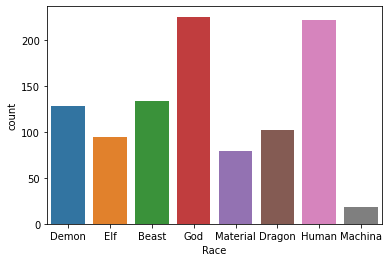

In [3]:
sns.countplot(x='Race', data=train_df) 

In [4]:
train_df

,id,Hit Point,Attack Point,Recovery,Total,Attribute,Race
0,977,1687,1656,489,3832,Water,Demon
1,72,185,87,159,431,Light,Elf
2,69,584,313,430,1327,Fire,Elf
3,493,1880,859,373,3112,Earth,Elf
4,443,905,364,49,1318,Water,Beast
...,...,...,...,...,...,...,...
995,1050,1473,1898,356,3727,Fire,Demon
996,999,2600,100,100,2800,Earth,Material
997,27,1133,475,128,1736,Fire,Beast
998,789,3063,1241,355,4659,Earth,God


# Preprocess

In [5]:
def race_to_idx(race):
  race_map = {
      'God': 0,
      'Human':1,
      'Demon':2,
      'Beast':3,
      'Dragon':4,
      'Elf':5,
      'Machina':6,
      'Material':7
  }
  return race_map[race]

def idx_to_race(idx):
  race_map = ['God', 'Human', 'Demon', 'Beast', 'Dragon', 'Elf', 'Machina', 'Material']
  return race_map[idx]

class ToS(Dataset):
  def __init__(self, data, mode):
    
    X = data.loc[:,'Hit Point': 'Attribute']
    X = X.join(pd.get_dummies(X['Attribute']))
    X = X.drop(['Attribute'], axis = 1)
    self.X = torch.from_numpy(X.to_numpy()).to(torch.float)
    
    if mode == 'train':
      
      Y_race = data['Race'].to_numpy()
      Y = []
      for i in range(len(Y_race)):
        Y.append(race_to_idx(Y_race[i]))
      self.Y = torch.Tensor(Y).to(torch.float)

    elif mode == 'test':
      Y = np.full(len(data), -1)
      self.Y = torch.from_numpy(Y).to(torch.float)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]


In [6]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)
train_data = train_df.loc[:int(len(train_df)*0.8)]
valid_data = train_df.loc[int(len(train_df)*0.8):]
train_loader = DataLoader(ToS(train_data,'train'), batch_size=64, shuffle=True)
valid_loader = DataLoader(ToS(valid_data,'train'), batch_size=64, shuffle=True)

# Define Model & Hyperparemeter

In [7]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN,self).__init__()
    self.linear1 = nn.Linear(9,180)
    self.linear2 = nn.Linear(180, 8)
    self.dropout = nn.Dropout(0.2)
    self.relu = nn.ReLU()

        
  def forward(self,x):
    x = self.linear1(x)
    x = self.dropout(x)
    x = self.relu(x) 
    x = self.linear2(x)
    return x

In [8]:
device = device("cuda" if is_available() else "cpu")
print(device)

cuda


In [9]:
learning_rate = 0.005
num_epochs = 100
weight_decay = 0.005

model = DNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [10]:
print(model)

DNN(
  (linear1): Linear(in_features=9, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


# Training & Validation

In [11]:
# Accurarcy
def accurarcy(predict, answer):
  correct = 0
  for i in range(len(predict)):
    if int(predict[i]) == int(answer[i]):
      correct += 1
  return correct / len(predict)

In [17]:
best_acc = 0
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0
  model.train()
  predict = []
  answer = []
  for step, (X, target) in enumerate(train_loader):
    optimizer.zero_grad()
    y = model(X.to(device))
    predict += torch.argmax(y, 1).tolist()
    answer += target.tolist()
    loss = criterion(y, target.to(device, dtype=int64))
    loss.backward()
    epoch_loss += loss.item()
    optimizer.step()
  acc = accurarcy(predict,answer)
  if acc > best_acc:
    best_acc = acc
  print("epoch: %3d, training loss: %.3f, accurarcy: %.3f"%(epoch, epoch_loss, acc))


print("\nDone, Best acc is {}".format(best_acc))

 28%|██▊       | 28/100 [00:00<00:00, 137.82it/s]

epoch:   0, training loss: 11.158, accurarcy: 0.632
epoch:   1, training loss: 7.929, accurarcy: 0.657
epoch:   2, training loss: 5.825, accurarcy: 0.647
epoch:   3, training loss: 10.040, accurarcy: 0.592
epoch:   4, training loss: 6.387, accurarcy: 0.642
epoch:   5, training loss: 8.754, accurarcy: 0.622
epoch:   6, training loss: 5.500, accurarcy: 0.657
epoch:   7, training loss: 8.564, accurarcy: 0.622
epoch:   8, training loss: 5.591, accurarcy: 0.612
epoch:   9, training loss: 3.926, accurarcy: 0.647
epoch:  10, training loss: 5.535, accurarcy: 0.662
epoch:  11, training loss: 6.111, accurarcy: 0.642
epoch:  12, training loss: 7.008, accurarcy: 0.622
epoch:  13, training loss: 4.251, accurarcy: 0.642
epoch:  14, training loss: 3.957, accurarcy: 0.687
epoch:  15, training loss: 6.204, accurarcy: 0.607
epoch:  16, training loss: 4.052, accurarcy: 0.677
epoch:  17, training loss: 4.995, accurarcy: 0.682
epoch:  18, training loss: 4.694, accurarcy: 0.652
epoch:  19, training loss: 4.

 56%|█████▌    | 56/100 [00:00<00:00, 135.68it/s]

epoch:  28, training loss: 5.608, accurarcy: 0.662
epoch:  29, training loss: 3.187, accurarcy: 0.672
epoch:  30, training loss: 2.797, accurarcy: 0.706
epoch:  31, training loss: 3.479, accurarcy: 0.642
epoch:  32, training loss: 2.954, accurarcy: 0.682
epoch:  33, training loss: 4.100, accurarcy: 0.701
epoch:  34, training loss: 6.284, accurarcy: 0.637
epoch:  35, training loss: 3.774, accurarcy: 0.657
epoch:  36, training loss: 4.230, accurarcy: 0.657
epoch:  37, training loss: 2.934, accurarcy: 0.697
epoch:  38, training loss: 4.847, accurarcy: 0.652
epoch:  39, training loss: 3.410, accurarcy: 0.672
epoch:  40, training loss: 3.081, accurarcy: 0.672
epoch:  41, training loss: 3.113, accurarcy: 0.701
epoch:  42, training loss: 3.084, accurarcy: 0.731
epoch:  43, training loss: 2.448, accurarcy: 0.726
epoch:  44, training loss: 4.612, accurarcy: 0.667
epoch:  45, training loss: 4.036, accurarcy: 0.652
epoch:  46, training loss: 3.060, accurarcy: 0.662
epoch:  47, training loss: 3.68

 85%|████████▌ | 85/100 [00:00<00:00, 136.14it/s]

epoch:  56, training loss: 3.121, accurarcy: 0.697
epoch:  57, training loss: 2.833, accurarcy: 0.657
epoch:  58, training loss: 4.384, accurarcy: 0.677
epoch:  59, training loss: 3.779, accurarcy: 0.687
epoch:  60, training loss: 3.539, accurarcy: 0.687
epoch:  61, training loss: 2.670, accurarcy: 0.701
epoch:  62, training loss: 2.856, accurarcy: 0.662
epoch:  63, training loss: 2.437, accurarcy: 0.716
epoch:  64, training loss: 2.413, accurarcy: 0.716
epoch:  65, training loss: 2.465, accurarcy: 0.731
epoch:  66, training loss: 2.382, accurarcy: 0.731
epoch:  67, training loss: 2.519, accurarcy: 0.746
epoch:  68, training loss: 2.950, accurarcy: 0.726
epoch:  69, training loss: 2.188, accurarcy: 0.766
epoch:  70, training loss: 2.368, accurarcy: 0.741
epoch:  71, training loss: 2.282, accurarcy: 0.726
epoch:  72, training loss: 2.788, accurarcy: 0.701
epoch:  73, training loss: 2.578, accurarcy: 0.721
epoch:  74, training loss: 3.042, accurarcy: 0.726
epoch:  75, training loss: 2.38

100%|██████████| 100/100 [00:00<00:00, 133.88it/s]

epoch:  85, training loss: 2.381, accurarcy: 0.736
epoch:  86, training loss: 2.063, accurarcy: 0.751
epoch:  87, training loss: 2.444, accurarcy: 0.706
epoch:  88, training loss: 2.535, accurarcy: 0.716
epoch:  89, training loss: 2.813, accurarcy: 0.746
epoch:  90, training loss: 2.110, accurarcy: 0.756
epoch:  91, training loss: 2.134, accurarcy: 0.726
epoch:  92, training loss: 2.108, accurarcy: 0.766
epoch:  93, training loss: 2.434, accurarcy: 0.731
epoch:  94, training loss: 2.244, accurarcy: 0.746
epoch:  95, training loss: 2.129, accurarcy: 0.781
epoch:  96, training loss: 2.022, accurarcy: 0.781
epoch:  97, training loss: 2.415, accurarcy: 0.726
epoch:  98, training loss: 2.040, accurarcy: 0.721
epoch:  99, training loss: 2.109, accurarcy: 0.706

Done, Best acc is 0.7810945273631841


In [18]:
best_acc = 0
for epoch in tqdm(range(num_epochs)):
  valid_loss = 0
  model.eval()
  predict = []
  answer = []
  with no_grad():
    for step, (X, target) in enumerate(valid_loader):    
      y = model(X.to(device))
      predict += torch.argmax(y, 1).tolist()
      answer += target.tolist()
      loss = criterion(y, target.view(-1).to(device, dtype=int64))
      valid_loss += loss.item()  
  acc = accurarcy(predict,answer)
  if acc > best_acc:
    best_acc = acc
  print("epoch: %3d, validation loss: %.3f, accurarcy: %.3f"%(epoch, valid_loss, acc))

print("\nDone, Best acc is {}".format(best_acc))

 22%|██▏       | 22/100 [00:00<00:00, 104.54it/s]

epoch:   0, validation loss: 11.439, accurarcy: 0.818
epoch:   1, validation loss: 10.816, accurarcy: 0.818
epoch:   2, validation loss: 10.828, accurarcy: 0.818
epoch:   3, validation loss: 11.743, accurarcy: 0.818
epoch:   4, validation loss: 10.775, accurarcy: 0.818
epoch:   5, validation loss: 11.570, accurarcy: 0.818
epoch:   6, validation loss: 10.768, accurarcy: 0.818
epoch:   7, validation loss: 11.842, accurarcy: 0.818
epoch:   8, validation loss: 10.904, accurarcy: 0.818
epoch:   9, validation loss: 10.812, accurarcy: 0.818
epoch:  10, validation loss: 10.709, accurarcy: 0.818
epoch:  11, validation loss: 10.953, accurarcy: 0.818
epoch:  12, validation loss: 10.874, accurarcy: 0.818
epoch:  13, validation loss: 11.091, accurarcy: 0.818
epoch:  14, validation loss: 10.776, accurarcy: 0.818
epoch:  15, validation loss: 10.749, accurarcy: 0.818
epoch:  16, validation loss: 11.012, accurarcy: 0.818
epoch:  17, validation loss: 10.861, accurarcy: 0.818
epoch:  18, validation loss:

 43%|████▎     | 43/100 [00:00<00:00, 104.27it/s]

epoch:  22, validation loss: 10.923, accurarcy: 0.818
epoch:  23, validation loss: 10.757, accurarcy: 0.818
epoch:  24, validation loss: 10.820, accurarcy: 0.818
epoch:  25, validation loss: 10.750, accurarcy: 0.818
epoch:  26, validation loss: 10.817, accurarcy: 0.818
epoch:  27, validation loss: 10.883, accurarcy: 0.818
epoch:  28, validation loss: 10.753, accurarcy: 0.818
epoch:  29, validation loss: 10.679, accurarcy: 0.818
epoch:  30, validation loss: 10.697, accurarcy: 0.818
epoch:  31, validation loss: 11.144, accurarcy: 0.818
epoch:  32, validation loss: 11.147, accurarcy: 0.818
epoch:  33, validation loss: 10.736, accurarcy: 0.818
epoch:  34, validation loss: 10.740, accurarcy: 0.818
epoch:  35, validation loss: 10.774, accurarcy: 0.818
epoch:  36, validation loss: 11.069, accurarcy: 0.818
epoch:  37, validation loss: 10.877, accurarcy: 0.818
epoch:  38, validation loss: 10.904, accurarcy: 0.818
epoch:  39, validation loss: 10.712, accurarcy: 0.818
epoch:  40, validation loss:

 64%|██████▍   | 64/100 [00:00<00:00, 104.47it/s]

epoch:  44, validation loss: 10.820, accurarcy: 0.818
epoch:  45, validation loss: 10.768, accurarcy: 0.818
epoch:  46, validation loss: 11.163, accurarcy: 0.818
epoch:  47, validation loss: 10.830, accurarcy: 0.818
epoch:  48, validation loss: 11.120, accurarcy: 0.818
epoch:  49, validation loss: 11.358, accurarcy: 0.818
epoch:  50, validation loss: 10.778, accurarcy: 0.818
epoch:  51, validation loss: 10.860, accurarcy: 0.818
epoch:  52, validation loss: 10.730, accurarcy: 0.818
epoch:  53, validation loss: 11.209, accurarcy: 0.818
epoch:  54, validation loss: 10.808, accurarcy: 0.818
epoch:  55, validation loss: 10.784, accurarcy: 0.818
epoch:  56, validation loss: 10.796, accurarcy: 0.818
epoch:  57, validation loss: 10.875, accurarcy: 0.818
epoch:  58, validation loss: 10.924, accurarcy: 0.818
epoch:  59, validation loss: 10.768, accurarcy: 0.818
epoch:  60, validation loss: 11.134, accurarcy: 0.818
epoch:  61, validation loss: 10.925, accurarcy: 0.818
epoch:  62, validation loss:

 85%|████████▌ | 85/100 [00:00<00:00, 101.94it/s]

epoch:  66, validation loss: 10.905, accurarcy: 0.818
epoch:  67, validation loss: 10.912, accurarcy: 0.818
epoch:  68, validation loss: 11.050, accurarcy: 0.818
epoch:  69, validation loss: 10.734, accurarcy: 0.818
epoch:  70, validation loss: 10.707, accurarcy: 0.818
epoch:  71, validation loss: 11.028, accurarcy: 0.818
epoch:  72, validation loss: 11.602, accurarcy: 0.818
epoch:  73, validation loss: 11.037, accurarcy: 0.818
epoch:  74, validation loss: 10.697, accurarcy: 0.818
epoch:  75, validation loss: 10.706, accurarcy: 0.818
epoch:  76, validation loss: 10.905, accurarcy: 0.818
epoch:  77, validation loss: 10.797, accurarcy: 0.818
epoch:  78, validation loss: 11.645, accurarcy: 0.818
epoch:  79, validation loss: 10.772, accurarcy: 0.818
epoch:  80, validation loss: 10.787, accurarcy: 0.818
epoch:  81, validation loss: 11.125, accurarcy: 0.818
epoch:  82, validation loss: 10.954, accurarcy: 0.818
epoch:  83, validation loss: 10.750, accurarcy: 0.818
epoch:  84, validation loss:

100%|██████████| 100/100 [00:00<00:00, 102.51it/s]

epoch:  87, validation loss: 10.769, accurarcy: 0.818
epoch:  88, validation loss: 10.931, accurarcy: 0.818
epoch:  89, validation loss: 10.693, accurarcy: 0.818
epoch:  90, validation loss: 10.881, accurarcy: 0.818
epoch:  91, validation loss: 11.007, accurarcy: 0.818
epoch:  92, validation loss: 10.864, accurarcy: 0.818
epoch:  93, validation loss: 10.877, accurarcy: 0.818
epoch:  94, validation loss: 10.794, accurarcy: 0.818
epoch:  95, validation loss: 11.714, accurarcy: 0.818
epoch:  96, validation loss: 10.840, accurarcy: 0.818
epoch:  97, validation loss: 10.866, accurarcy: 0.818
epoch:  98, validation loss: 11.105, accurarcy: 0.818
epoch:  99, validation loss: 11.036, accurarcy: 0.818

Done, Best acc is 0.8175


# Testing

In [19]:
test_loader = DataLoader(ToS(test_df,'test'), batch_size=64, shuffle=False)

In [20]:
ans = []
id = test_df['id'].values.tolist()
content = {'id':[], 'Race':[]}
model.eval()
with no_grad():
  for step, (X, target) in enumerate(test_loader):    
    y = model(X.to(device))
    ans += torch.argmax(y,1).tolist()

for i in range(len(ans)):
  content['id'].append(id[i])
  content['Race'].append(idx_to_race(ans[i]))      

In [21]:
df = pd.DataFrame(content)
df.to_csv("submission.csv", index=False)